In [18]:
import numpy as np
import cupy as cp
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib
gen = cp.random.default_rng()

%matplotlib inline

import os
os.environ["CUPY_ACCELERATORS"] = "cutensor,cub,python"
os.environ['CUPY_CUDA_PER_THREAD_DEFAULT_STREAM'] = "1"

In [19]:
def gillespie(n_ratio, N, M = 1):
    runs = []
    for i in range(M):
        Ns = [int(n_ratio * N / (n_ratio + 1))]
        Ns.append(N-Ns[0])
        g = [1, -1]
        cumulative = [0]
        counts = np.array([0, 0]) 
        r2 = gen.uniform(size = N)
        for j in range(N):
            a = [(Ns[i] - counts[i]) / (N - j) for i in range(2)]
            mu = 0
            n = r2[j] - a[mu]
            mu = int(n > 0)

            cumulative.append(cumulative[-1] + g[mu])
            counts[mu] += 1
    runs.append(np.array(cumulative))
    return runs
x = gillespie(1,100, 30)
print(x)

[array([ 0,  1,  0, -1, -2, -1, -2, -1,  0,  1,  2,  1,  0, -1, -2, -3, -4,
       -5, -4, -5, -6, -5, -6, -5, -6, -5, -6, -5, -6, -7, -6, -7, -8, -7,
       -6, -5, -6, -5, -6, -7, -6, -7, -6, -5, -4, -3, -4, -5, -4, -3, -4,
       -3, -2, -1, -2, -1, -2, -3, -2, -1, -2, -1,  0, -1,  0, -1,  0,  1,
        2,  3,  4,  3,  4,  3,  2,  3,  4,  3,  4,  3,  4,  5,  6,  5,  4,
        5,  6,  5,  6,  7,  6,  5,  6,  5,  4,  3,  2,  3,  2,  1,  0])]


In [22]:
def gillespie(n_ratio, N, M = 1):
    gen = np.random.default_rng()
    Ns = [[int(n_ratio * N / (n_ratio + 1))]]
    Ns[0].append(N-Ns[0][0])
    Ns = np.array(Ns).T
    g = np.array([1, -1])
    cumulative = np.zeros([N+1,M])
    counts = np.zeros([2,M])
    r2 = gen.uniform(size = [N+1,M])
    rang = range(M)
    for j in range(N):
        a = (Ns - counts) / (N-j)
        n = r2[j] - a[0]
        mu = (n > 0) + 0
        cumulative[j+1] = cumulative[j] + g[mu]
        counts[mu, rang] += 1
    return cumulative.T

x = gillespie(1,10,3000000)
print(x.shape)

(3000000, 11)


In [27]:
def gillespie(n_ratio, N, M = 1):
    Ns = [[int(n_ratio * N / (n_ratio + 1))]]
    Ns[0].append(N-Ns[0][0])
    Ns = cp.array(Ns).T
    g = cp.array([1, -1])
    cumulative = cp.zeros([N+1,M])
    counts = cp.zeros([2,M])
    r2 = gen.uniform(size = [N+1,M])
    rang = range(M)
    for j in range(N):
        a = (Ns - counts) / (N-j)
        n = r2[j] - a[0]
        mu = (n > 0) + 0
        cumulative[j+1] = cumulative[j] + g[mu]
        counts[mu, rang] += 1
    return cumulative.T

x = gillespie(1,10,3000000)
print(x.shape)

(3000000, 11)


In [31]:
print(os.environ["CUPY_ACCELERATORS"])
cp.get_default_memory_pool().used_bytes()

cutensor,cub,python


2282952192

In [22]:
def empirical_test(n_ratio, N, theta,j, M):
    successes = 0
    for i in range(M):
        run = gillespie(n_ratio, N)
        if run[j] == theta:
            successes += 1
    return successes / M


In [16]:
# testing hypergeometric distribution
N = 100
n_ratio = 1
Np = int(N * n_ratio / (n_ratio + 1))
j  = 99
theta = (2 * Np - N) * j / N
print(f'theta = {theta}')


suc = (theta + j) / 2
if suc % 1 == 0:
    true = sp.special.comb(Np, suc) * sp.special.comb(N - Np, j - suc) / sp.special.comb(N, j)
    print(f'True probability that theta({j}) = {theta} is {np.round(true,4)}')
else:
    true = 0
    print("impossible")

test = empirical_test(n_ratio, N, theta,j, 10000)
print(f'Sample estimate: {test}')

theta = 0.0
impossible
Sample estimate: 0.0


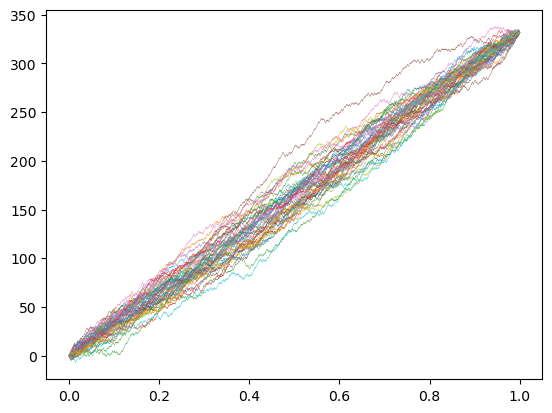

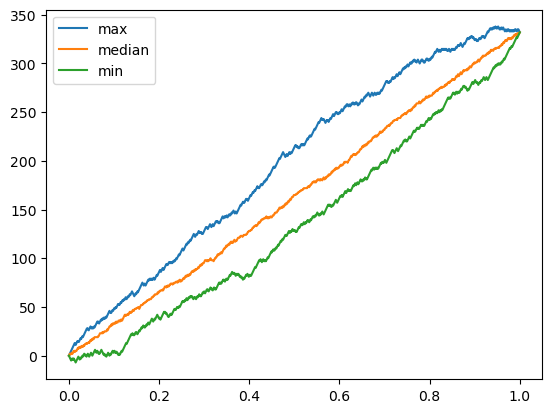

In [17]:
N = 1000
n_ratio = 2
M = 50
t = np.linspace(0, 1, N + 1)
x = np.array([gillespie(n_ratio, N) for _ in range(M)])

plt.plot(t, x.T,linewidth=0.3,alpha=1)
plt.show()
max = np.max(x,axis=0)
min = np.min(x,axis=0)
med = np.median(x,axis=0)
plt.plot(t, max,label="max")
plt.plot(t, med,label="median")
plt.plot(t, min,label="min")
plt.legend()
plt.show()

In [18]:
# find empirical distribution of intersection locations (with null path) and number of intersections
def intersection_density(n_ratio, N, M): 
    Ns = [int(n_ratio * N / (n_ratio + 1))]
    Ns.append(N-Ns[0])
    x0 = np.arange(N+1) * (Ns[0] - Ns[1]) / N
    intersections = np.zeros([M,N+1])
    for i in range(M):
        x = gillespie(n_ratio, N)
        y = x - x0
        # intersections[i,1:] = (np.sign(y[1:]) != np.sign(y[:-1]))
        intersections[i,1:] = y[1:] == 0
    inter_number = np.sum(intersections, axis = 1)
    inters = np.argwhere(intersections == 1).T[1] / N
    return inters, inter_number

In [19]:
n_ratios = [i for i in range(1,10)]
N1 = [i * 1000 for i in range(1,5)]
M = 1000
runs = []
for N in N1:
    runs.append([])
    for n_ratio in n_ratios:
        runs[-1].append(intersection_density(n_ratio, N, M))

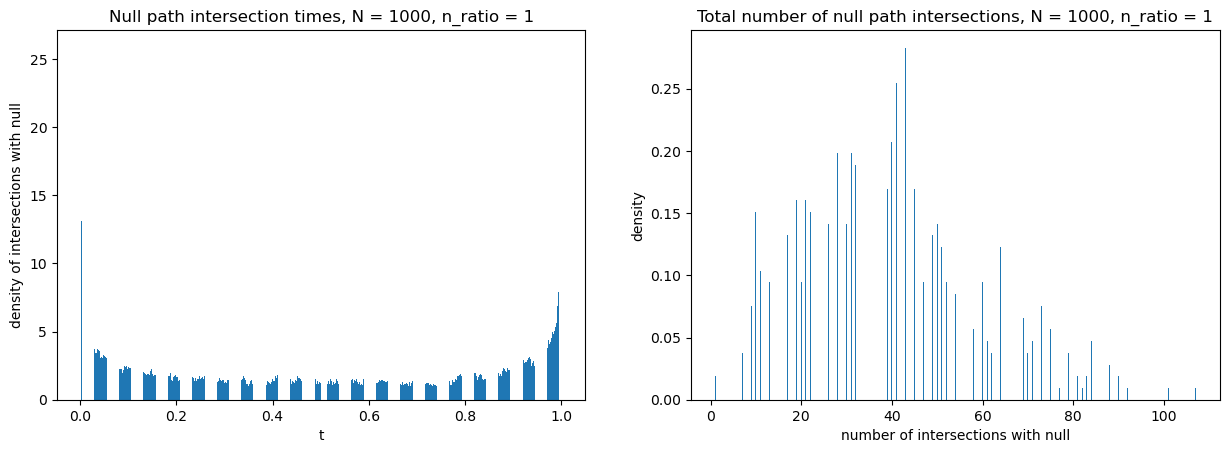

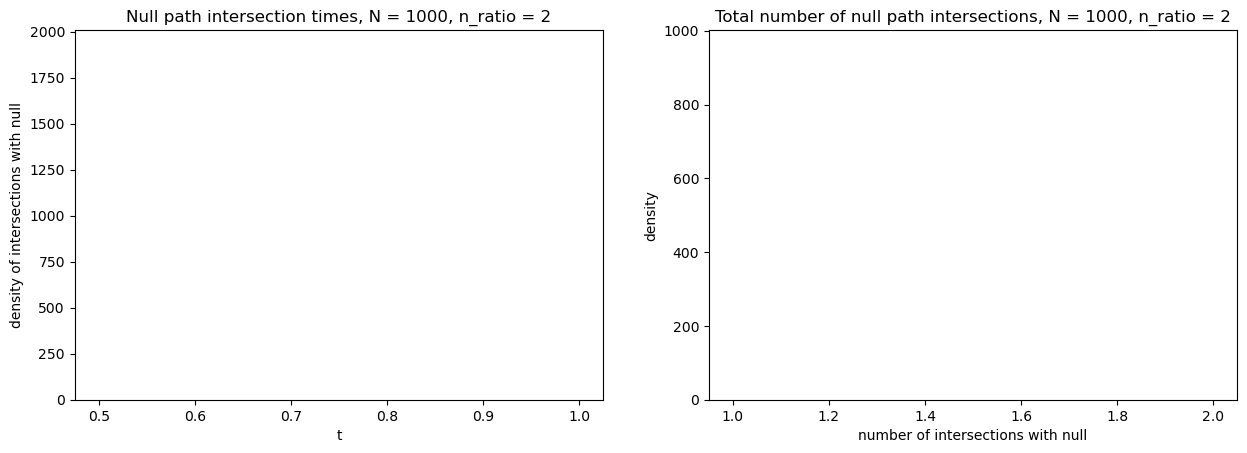

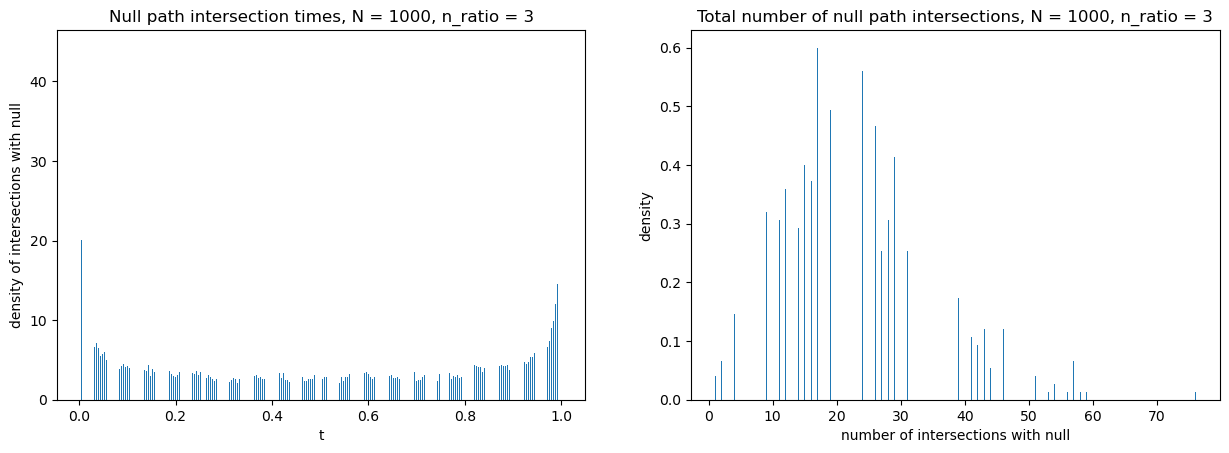

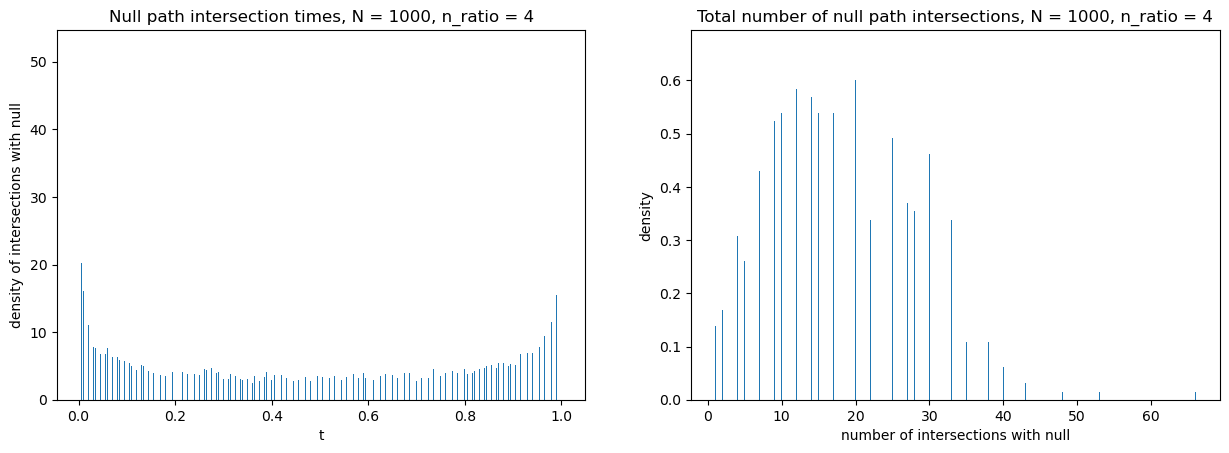

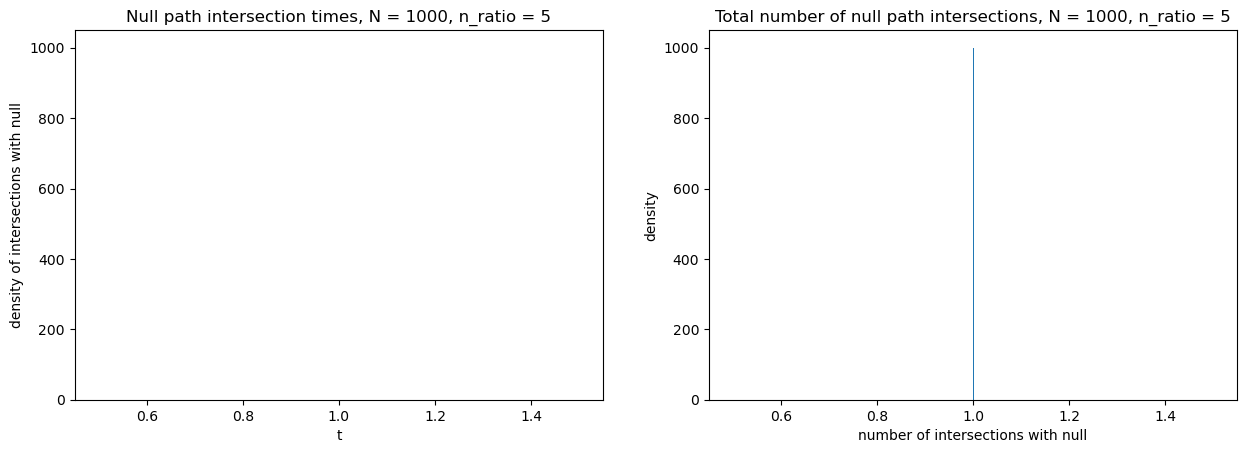

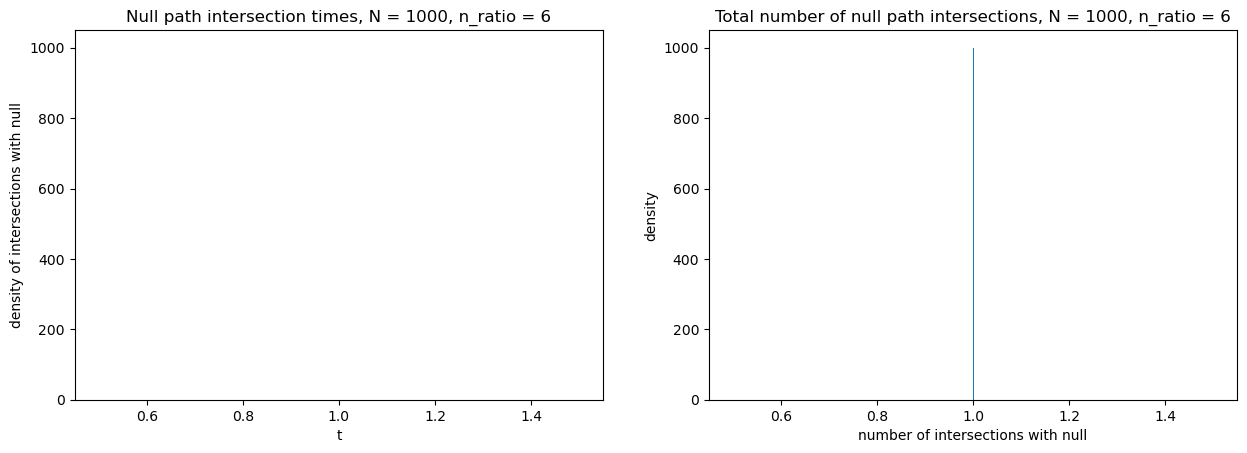

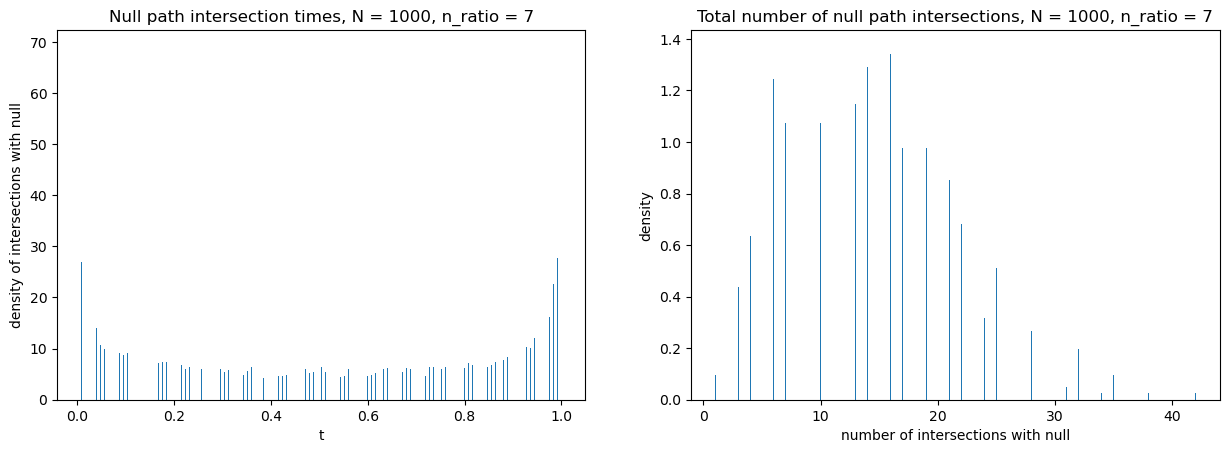

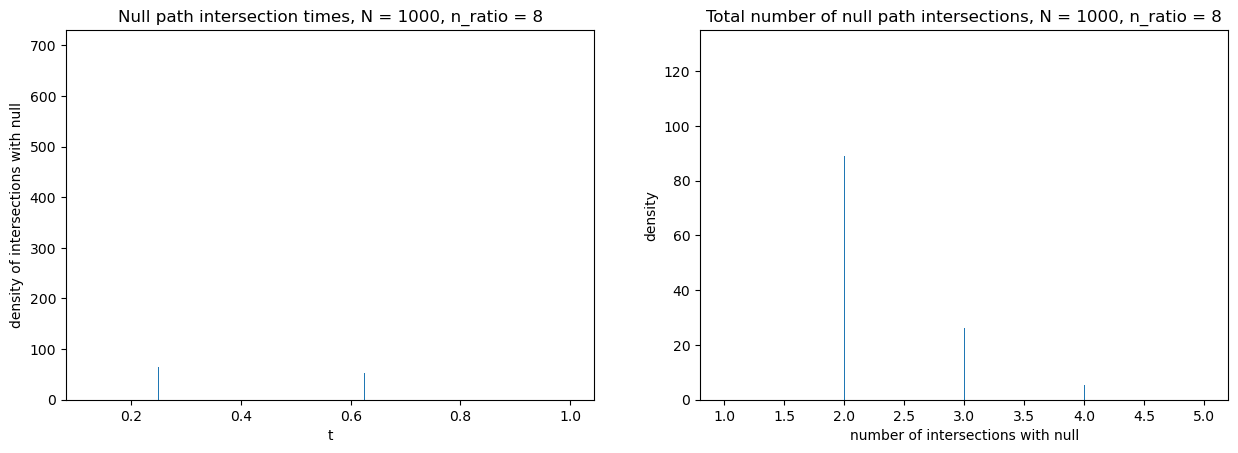

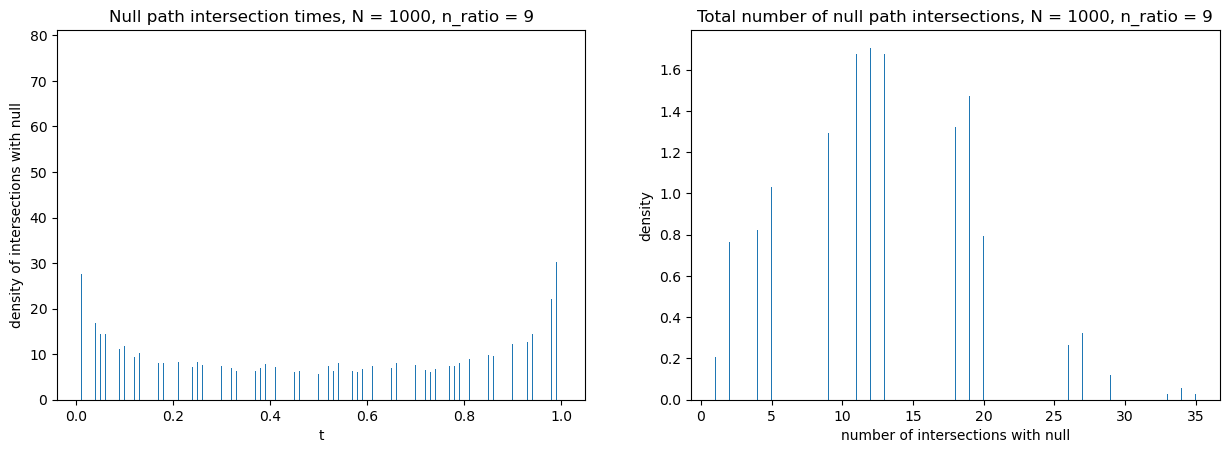

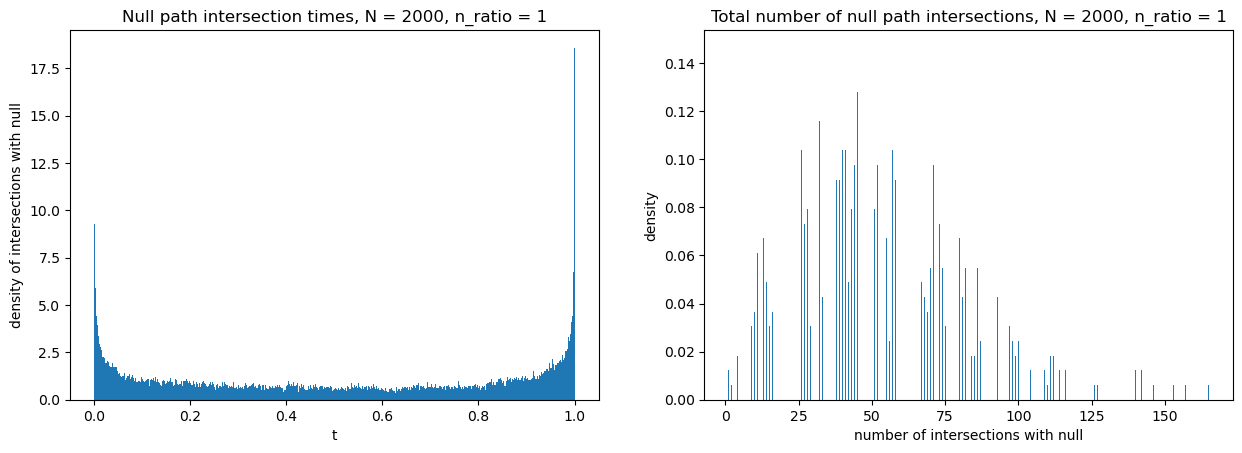

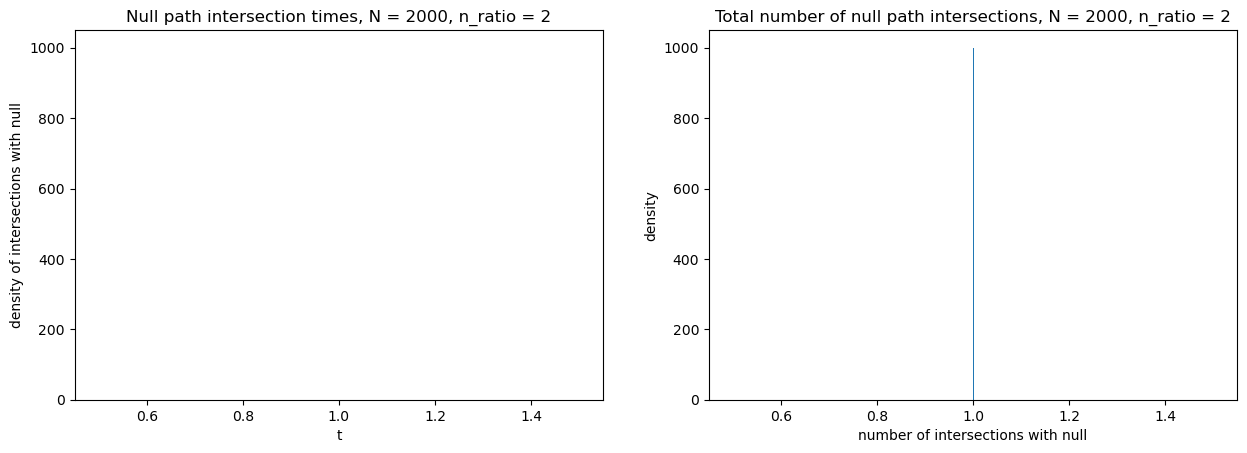

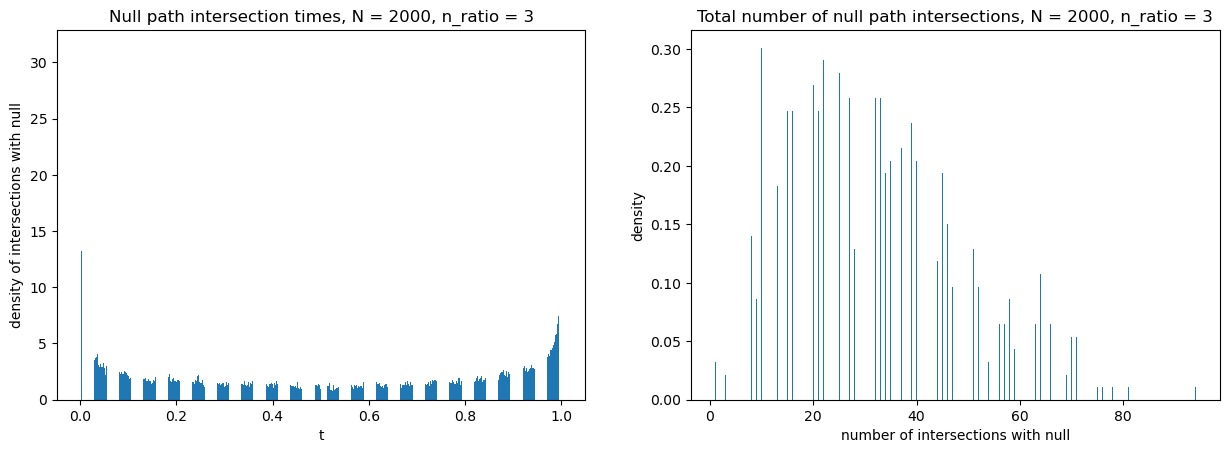

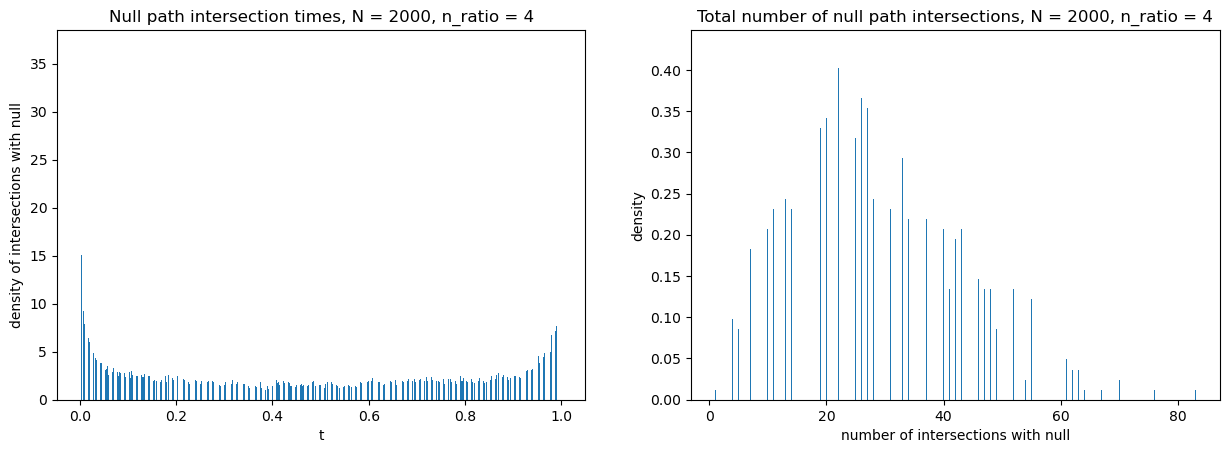

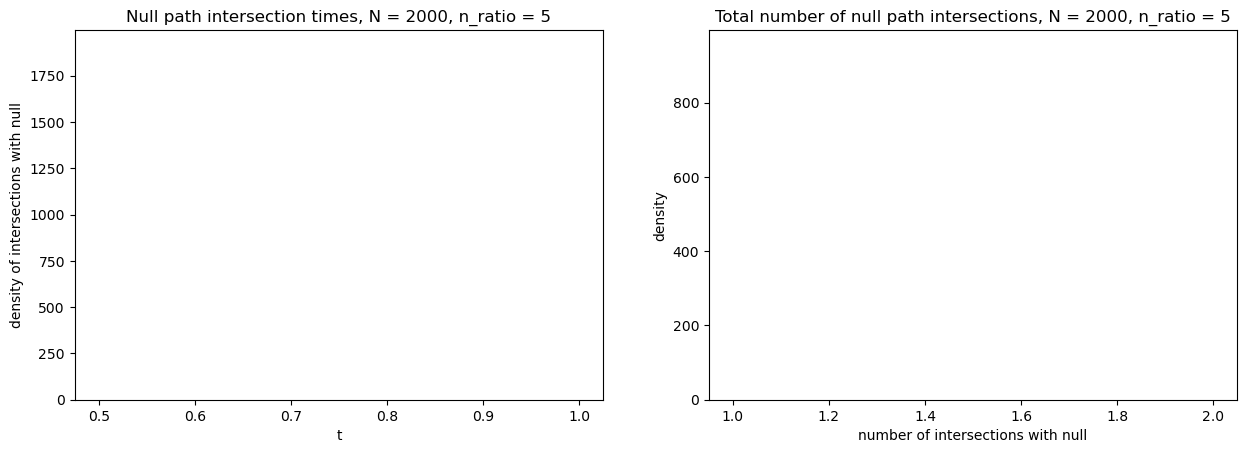

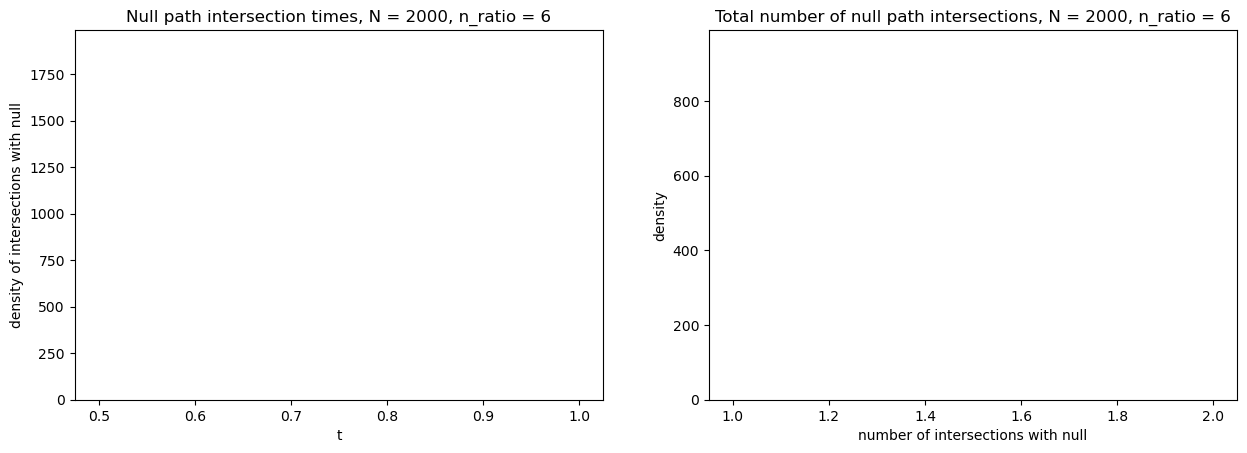

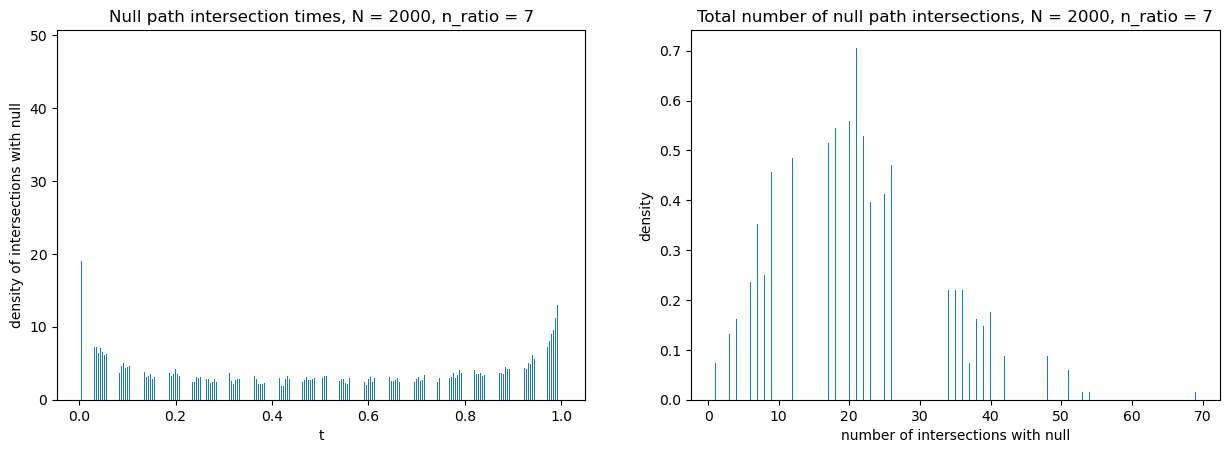

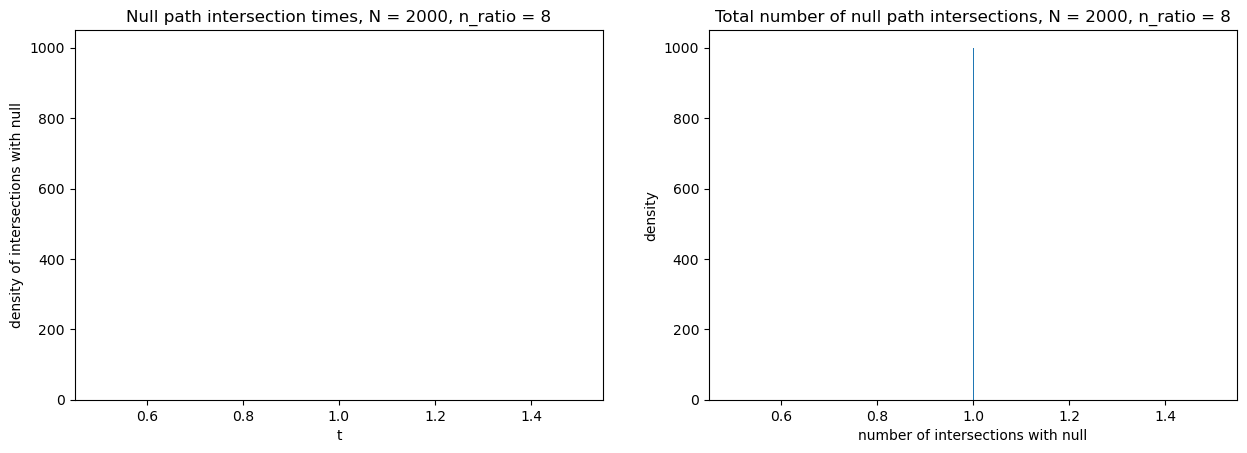

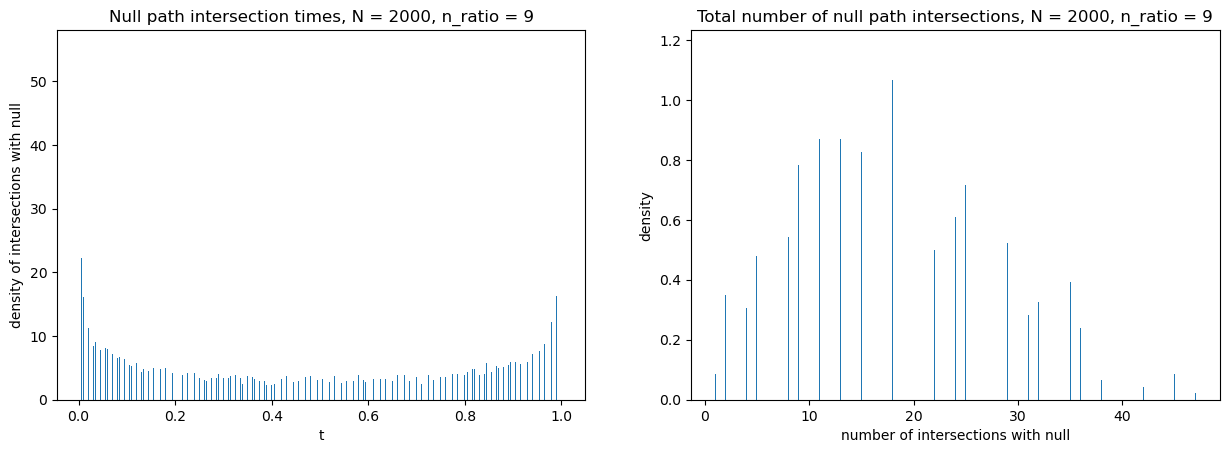

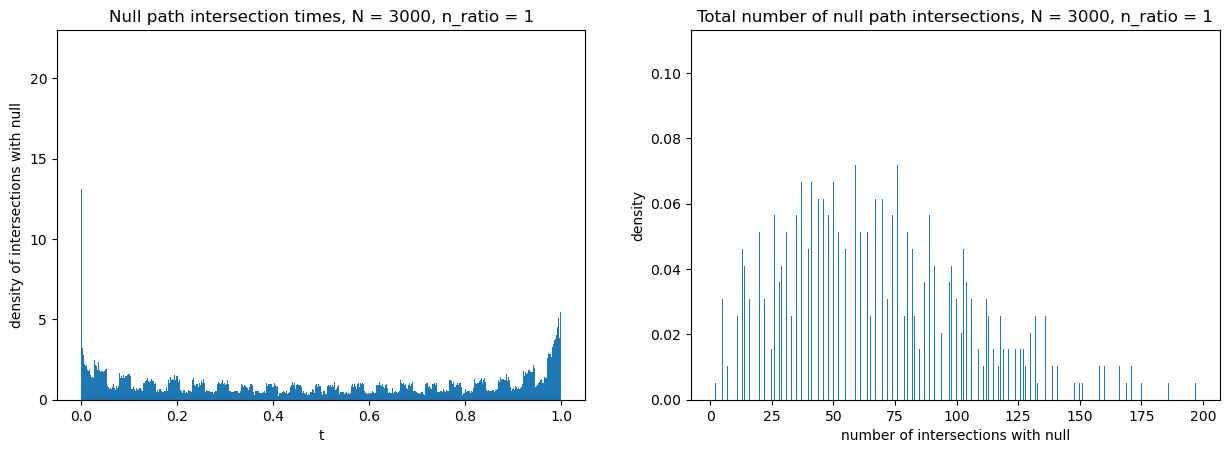

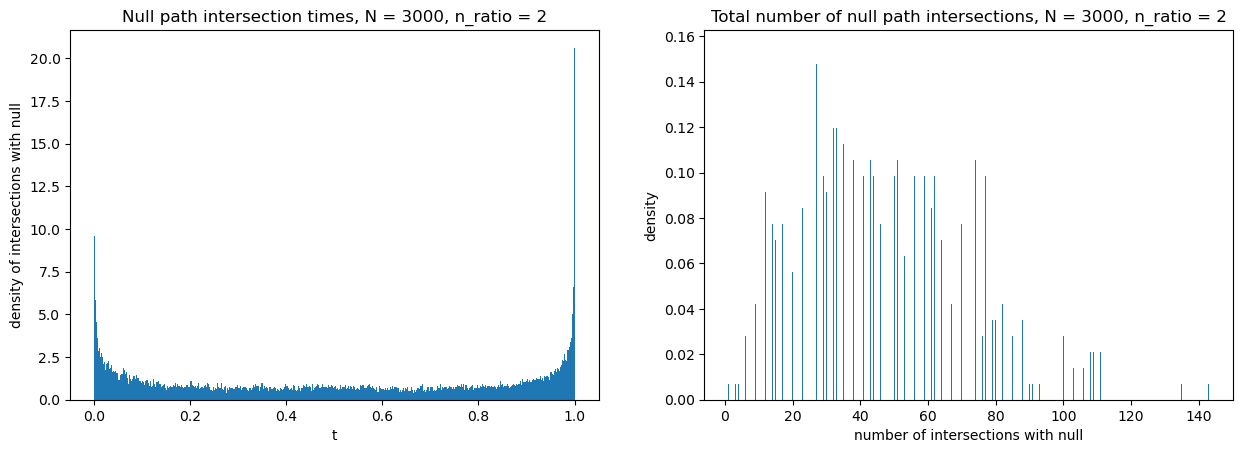

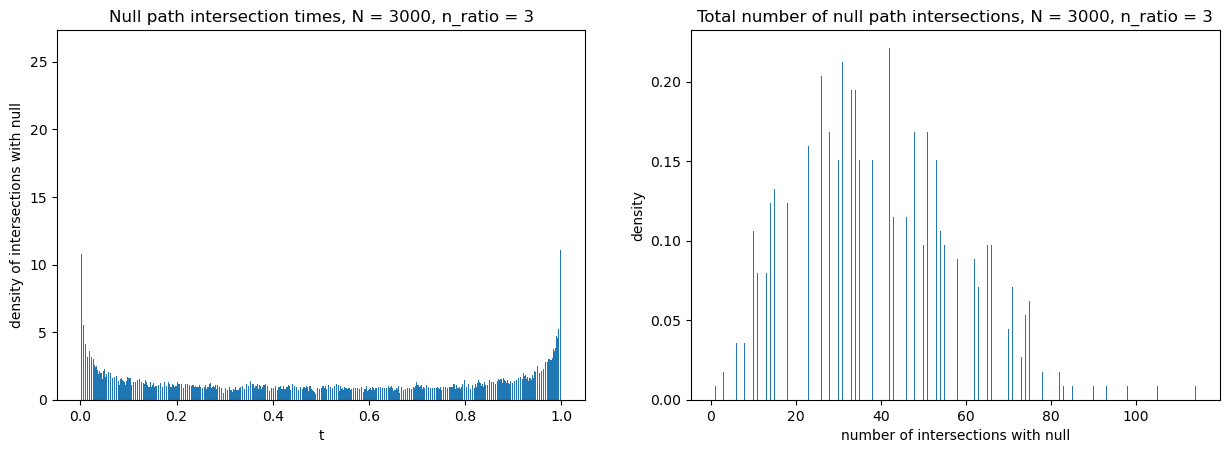

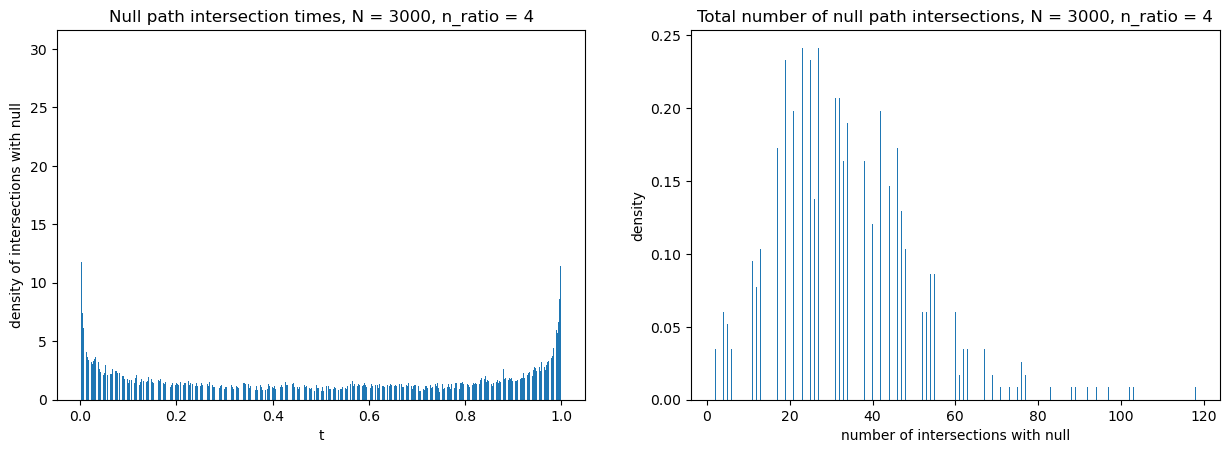

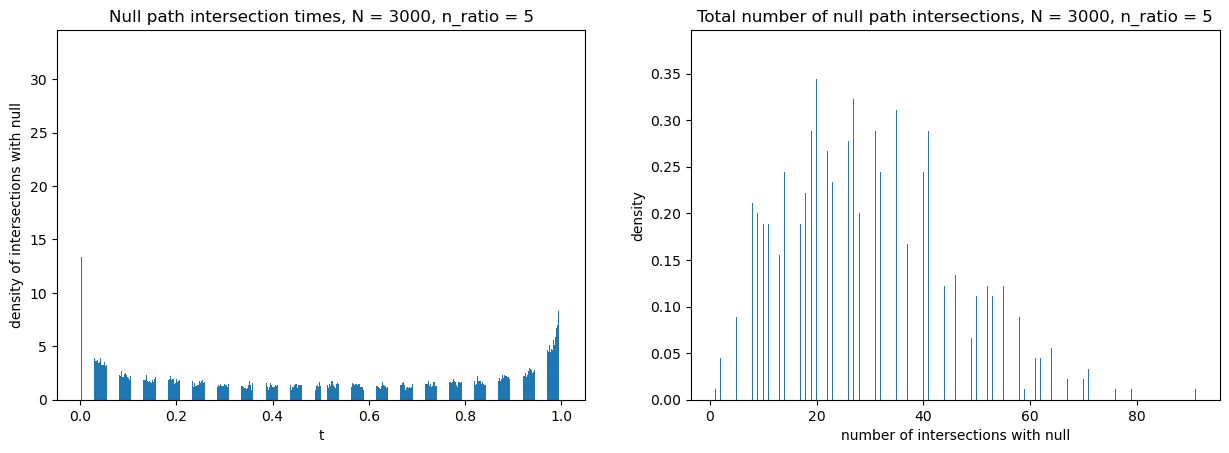

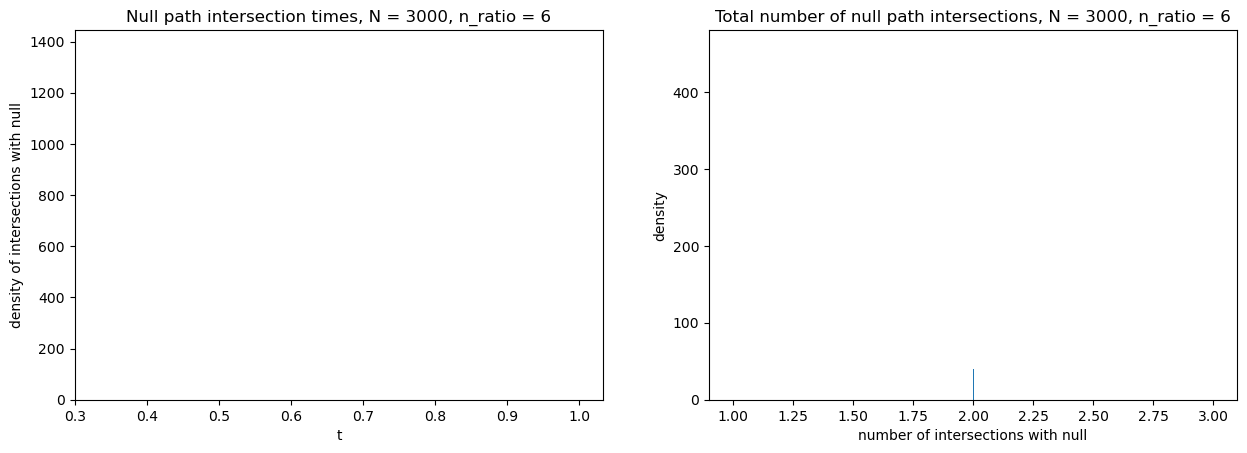

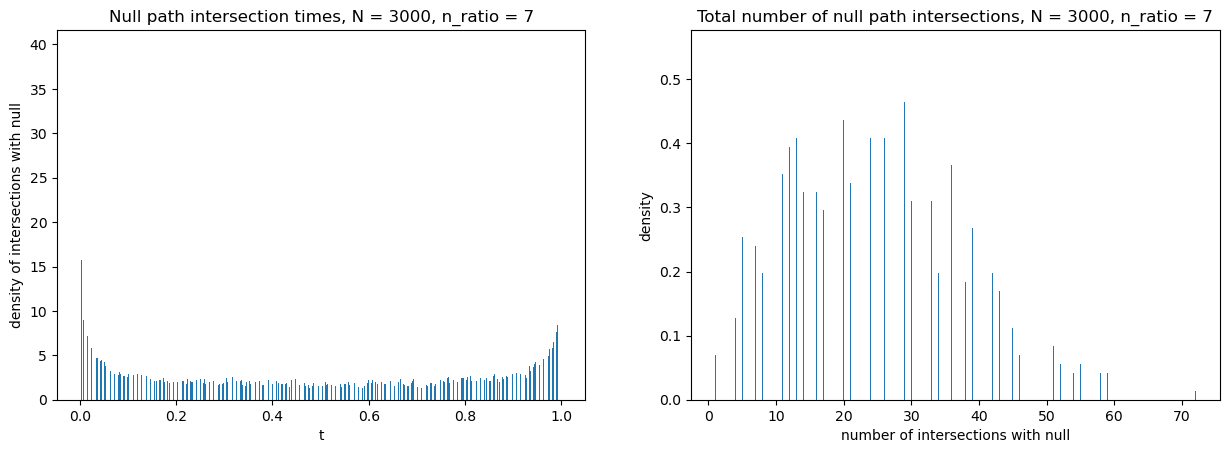

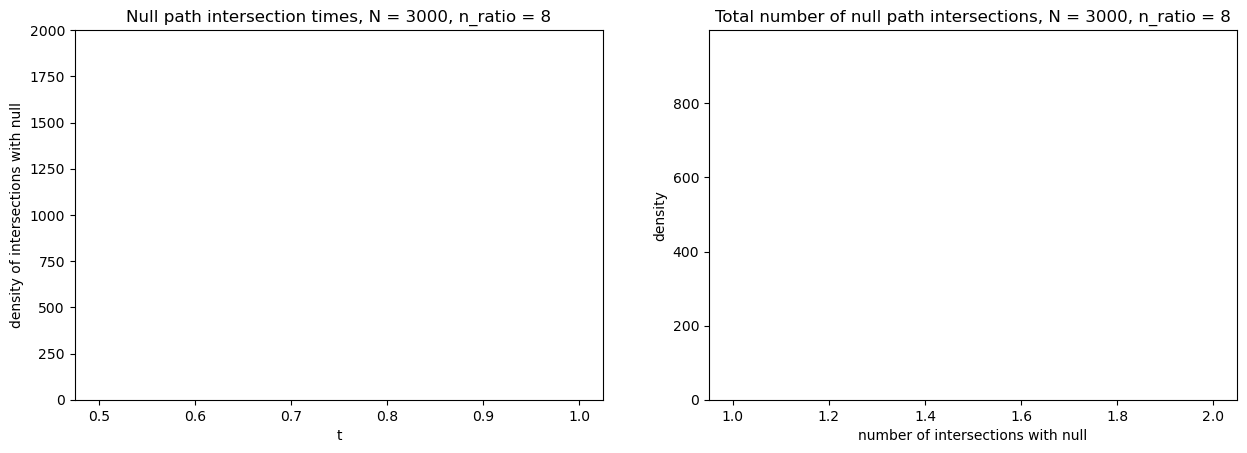

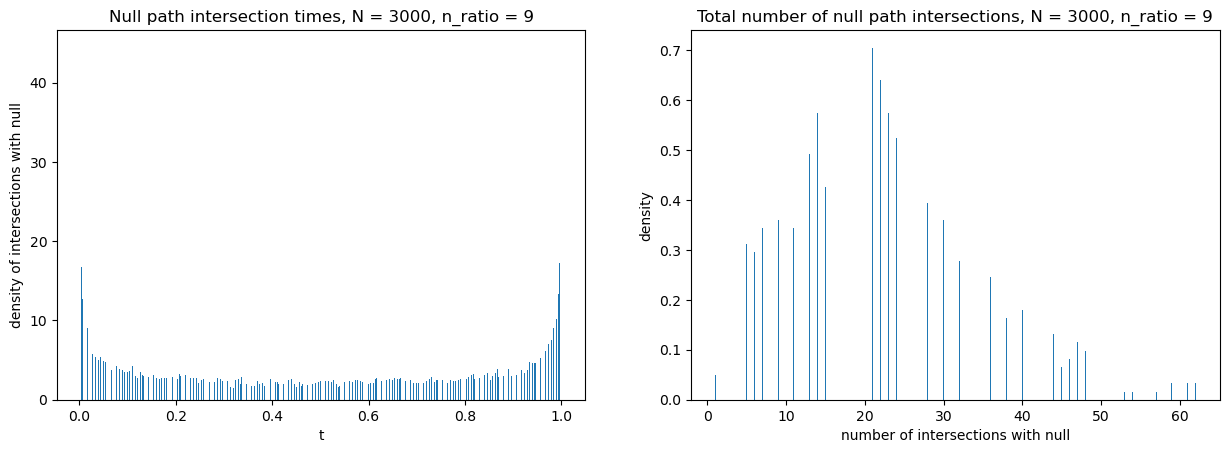

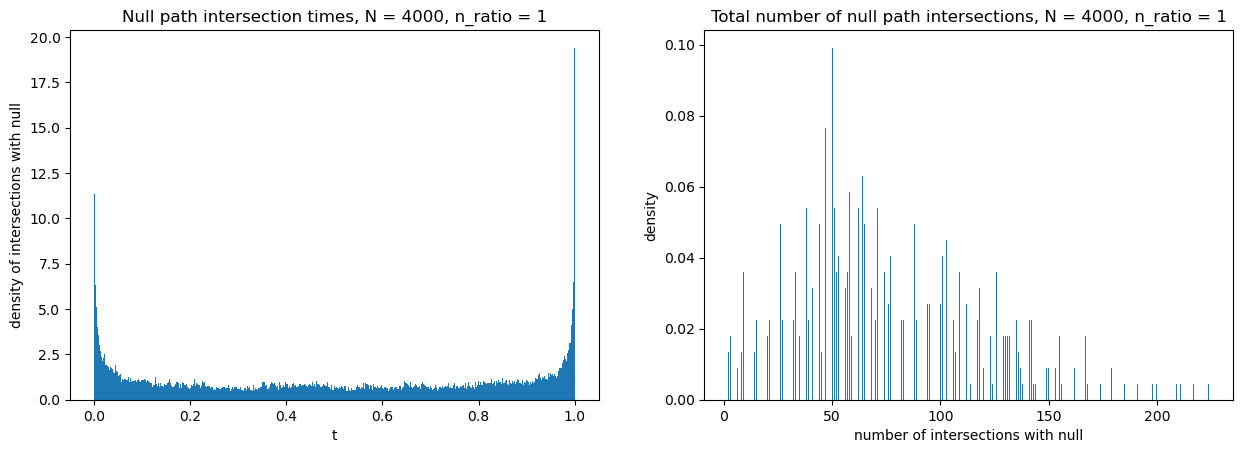

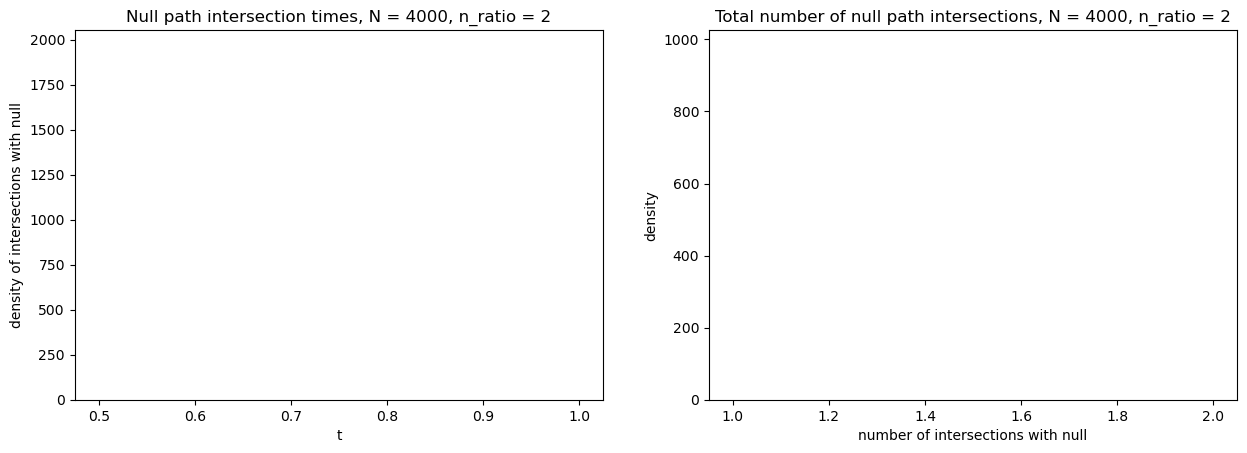

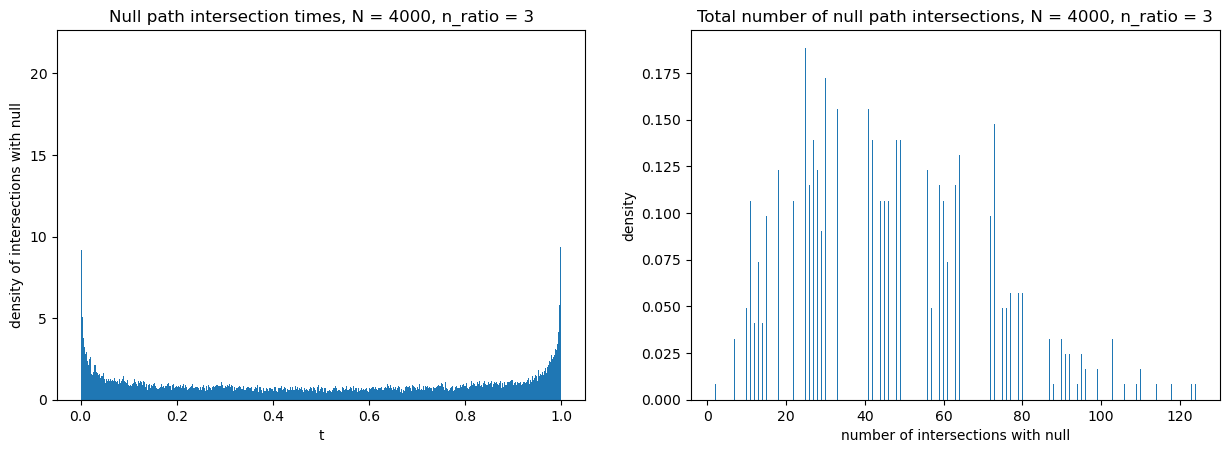

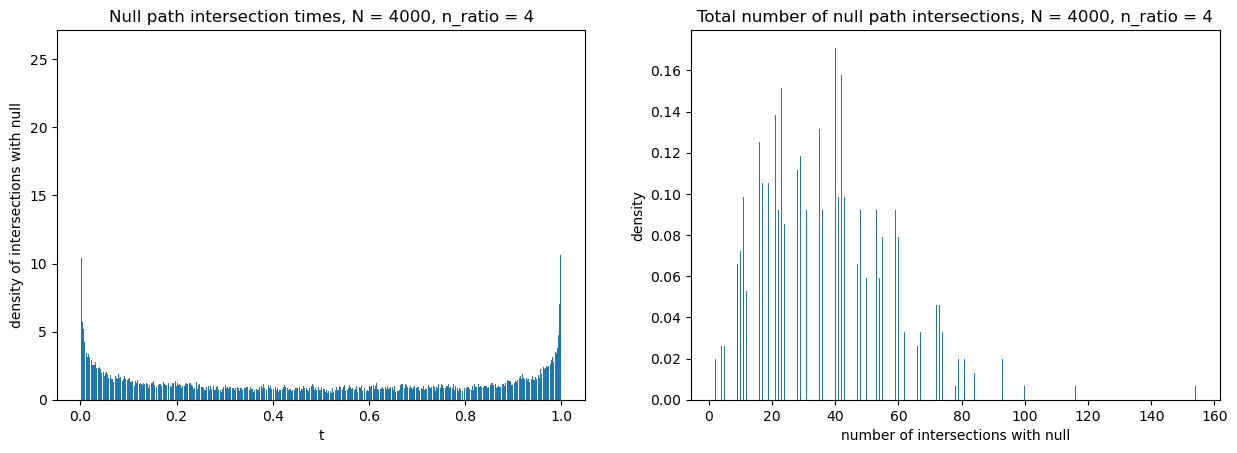

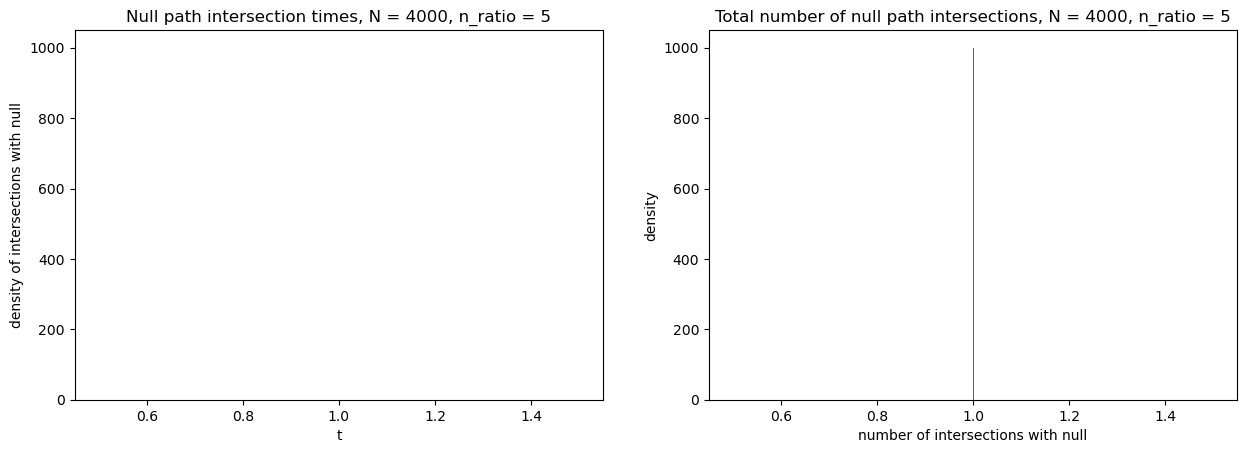

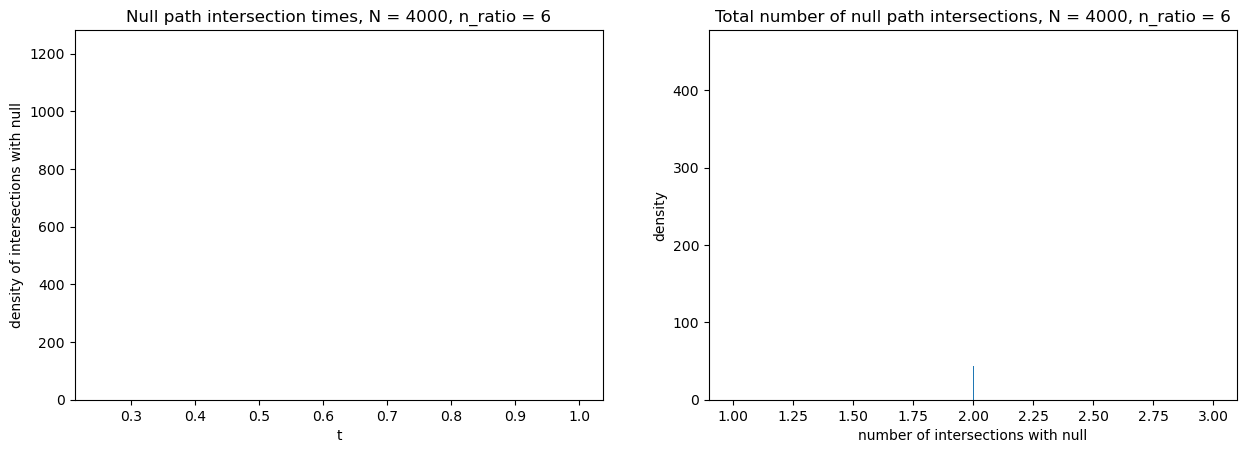

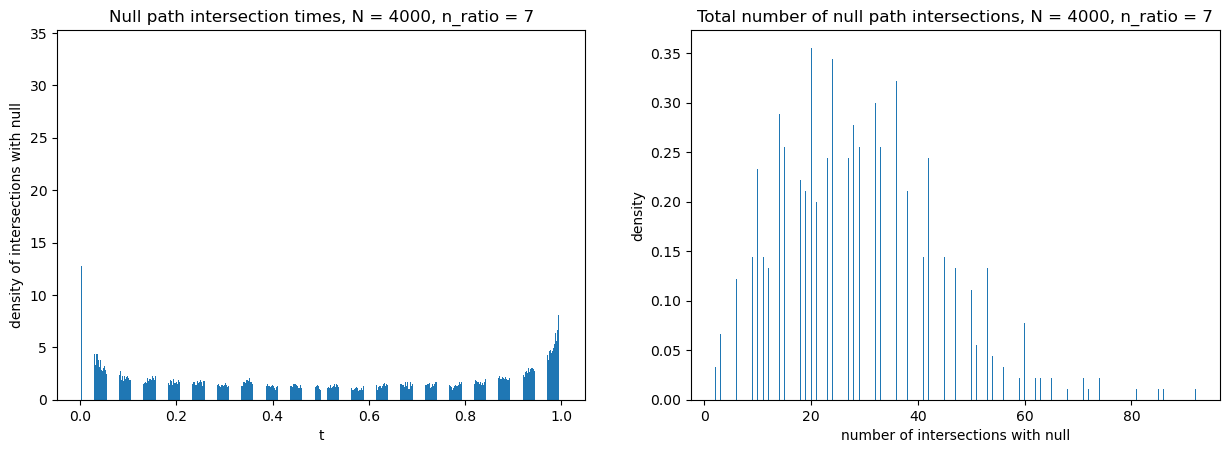

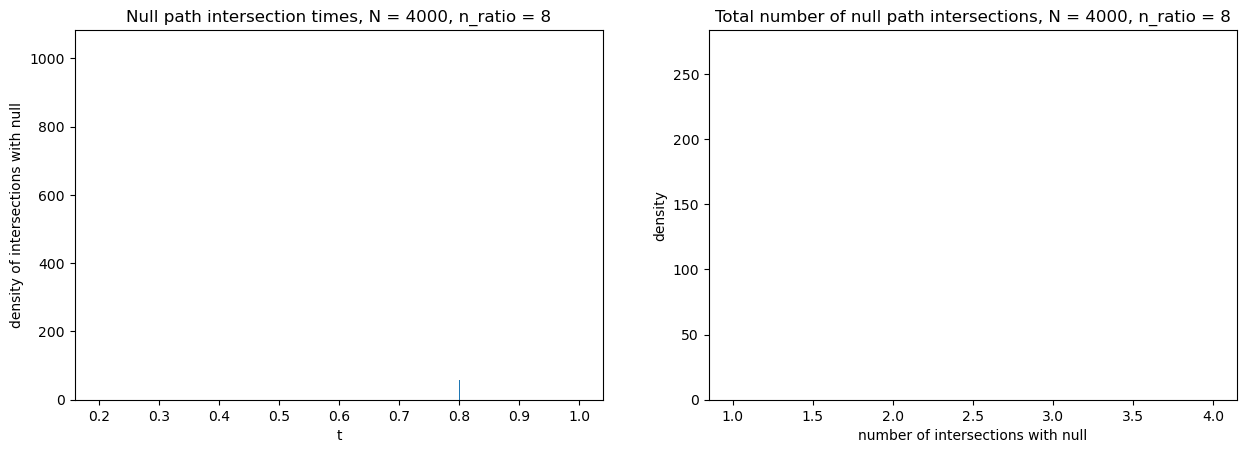

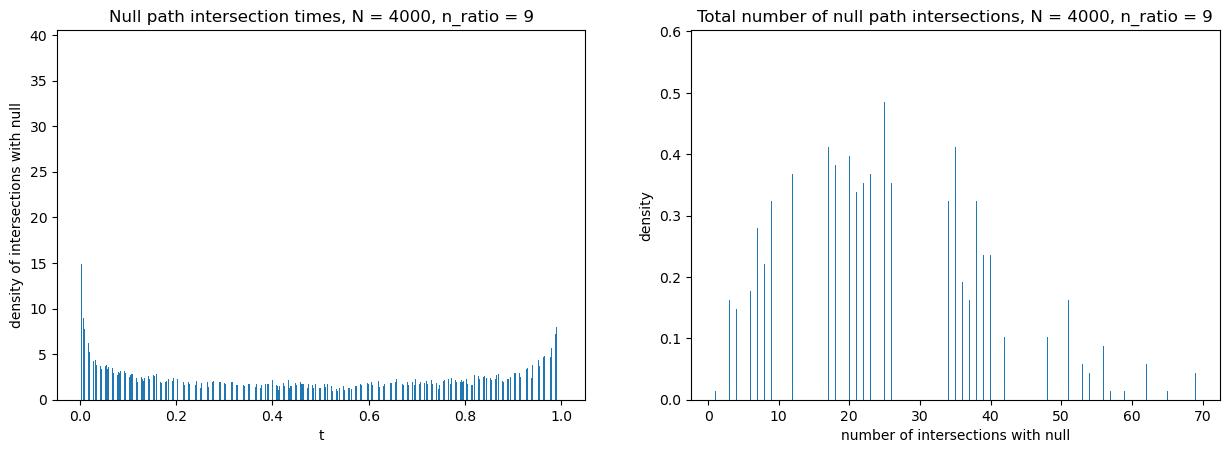

In [20]:
for i in range(len(N1)):
    for j in range(len(n_ratios)):
        inters, inter_number = runs[i][j]
        N = N1[i]
        n_ratio = n_ratios[j]
        fig, axs = plt.subplots(1,2)
        fig.set_figwidth(15)
        axs[0].hist(inters, bins = 1000, density = True)
        axs[0].set_title(f"Null path intersection times, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("density of intersections with null")
        
        axs[1].hist(inter_number, bins = 1000, density = True)
        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        plt.show()

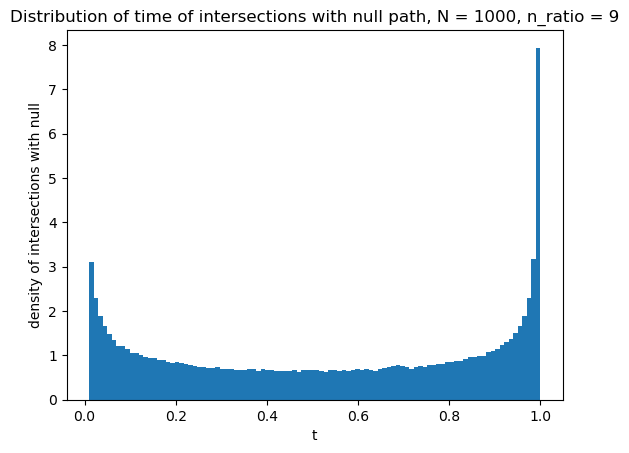

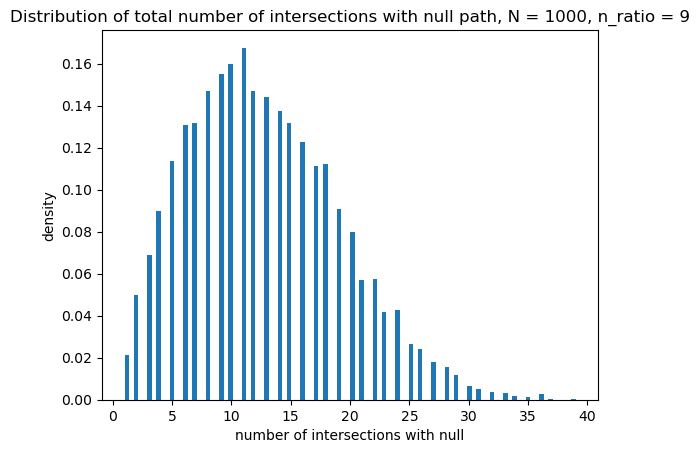

In [6]:
plt.hist(inters, bins = 100, density = True)
plt.title(f"Distribution of time of intersections with null path, N = {N}, n_ratio = {n_ratio}")
plt.xlabel("t")
plt.ylabel("density of intersections with null")
plt.show()

fig, ax = plt.subplots()
ax.hist(inter_number, bins = 100, density = True)
ax.set_title(f"Distribution of total number of intersections with null path, N = {N}, n_ratio = {n_ratio}")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")

# # Gamma distribution guess
# j = np.arange(300)
# a = 3.5
# gamma = st.gamma.pdf(j, a, scale = 60 / (a-1))
# ax.plot(j,gamma)
plt.show()

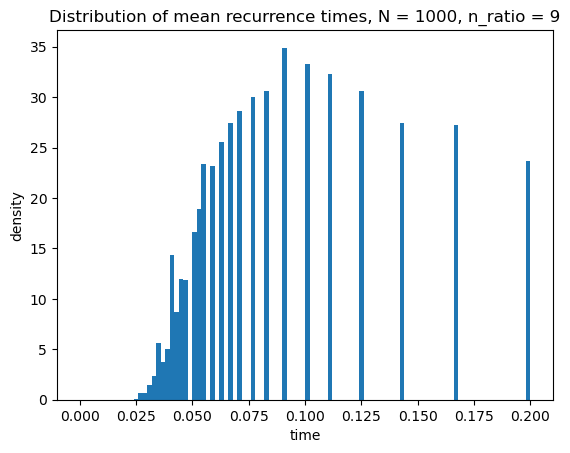

In [8]:
mean_recurrences = 1 / inter_number
print(f'mean of mean recurrence times = {np.mean(mean_recurrences)}')

fig, ax = plt.subplots()
ax.hist(mean_recurrences, bins = 100, density = True, range = [0,0.2])
ax.set_title(f"Distribution of mean recurrence times, N = {N}, n_ratio = {n_ratio}")
ax.set_xlabel("time")
ax.set_ylabel("density")
plt.show()

In [25]:
n_ratio = 1 # N0, N+, N-
N = 50000
big_inters, big_inter_number = intersection_density(n_ratio, N, M = 1000)

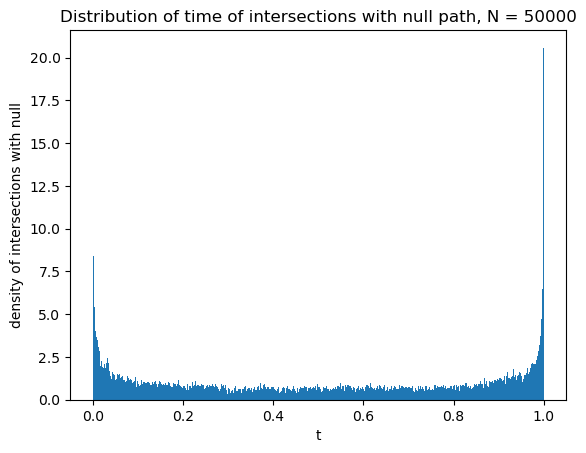

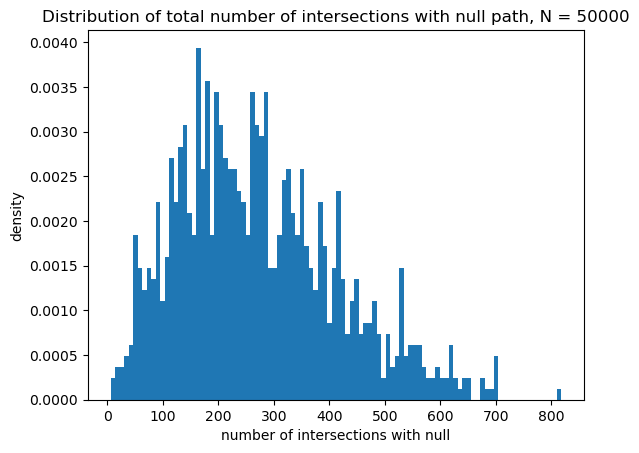

In [26]:
plt.hist(big_inters, bins = 1000, density = True)
plt.title(f"Distribution of time of intersections with null path, N = {N}")
plt.xlabel("t")
plt.ylabel("density of intersections with null")
plt.show()

fig, ax = plt.subplots()
ax.hist(big_inter_number, bins = 100, density = True)
ax.set_title(f"Distribution of total number of intersections with null path, N = {N}")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")    
# ax.plot(j,gamma)
plt.show()

In [27]:
big_mean_recurrences = 1 / big_inter_number
print(f'mean of mean recurrence times = {np.mean(big_mean_recurrences)}')

mean of mean recurrence times = 0.005726550930318585


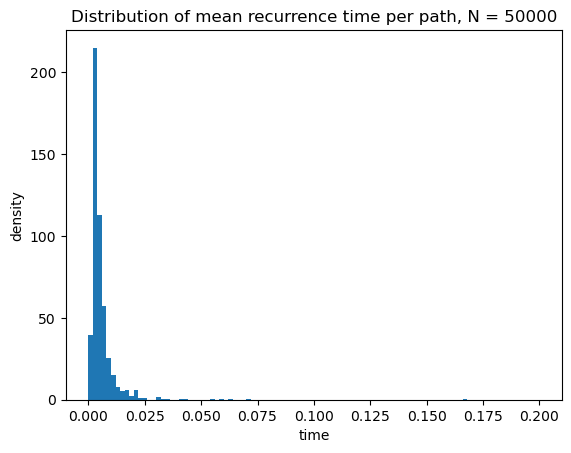

In [28]:
fig, ax = plt.subplots()
ax.hist(big_mean_recurrences, bins = 100, density = True, range = [0,0.2])
ax.set_title(f"Distribution of mean recurrence time per path, N = {N}")
ax.set_xlabel("time")
ax.set_ylabel("density")
plt.show()

In [142]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

def parametric(n_ratio, N, ax, c = None):

    x = gillespie(n_ratio, N)
    seq = np.array(x[1:] < x[:-1]) * 1
    parametric = [[0],[0]]
    for i in seq:
        parametric[i].append(parametric[i][-1] + 1)
        parametric[i-1].append(parametric[i-1][-1])
    parametric = np.array(parametric) / N
    
    ax.plot(parametric[0], parametric[1], label = f' +/- ratio={n_ratio}', c=c)
    ax.set_title("Path in parametric axes")
    ax.set_xlabel("x+")
    ax.set_ylabel("x-")
    return parametric

def parametric_shifted(n_ratio, N, path, ax):
    Ns = [int(n_ratio * N / (n_ratio + 1))]
    Ns.append(N-Ns[0])

    # shift by null path
    t = np.linspace(0, 1, N+1)
    shift_plus = Ns[0] / N * t
    shift_minus = Ns[1] / N * t
    x = path[0] - shift_plus
    y = path[1] - shift_minus


    points = np.array([x, y]).transpose().reshape(-1, 1, 2)
    # set up a list of segments
    # segs = np.concatenate([points[:-1],points[1:]],axis=1)
    segs = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1)

    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('viridis'))

    lc.set_array(t)  # color the segments by our parameter

    # plot the collection

    ax.add_collection(lc)  # add the collection to the plot

    a = list(ax.get_xlim())
    b = list(ax.get_ylim())
    a = [np.min([a[0], x.min()]), np.max([a[1], x.max()])]
    b = [np.min([b[0], y.min()]), np.max([b[1], y.max()])]

    ax.set_xlim(a)
    ax.set_ylim(b)

    ax.set_title("Parametric path shifted by null path")
    ax.set_xlabel("y+")
    ax.set_ylabel("y-")

    return np.array([x, y])

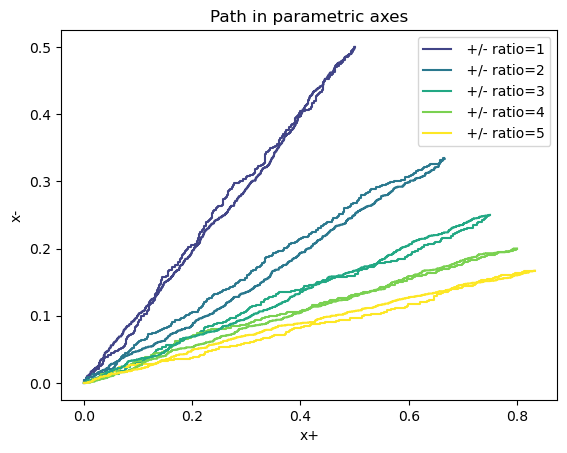

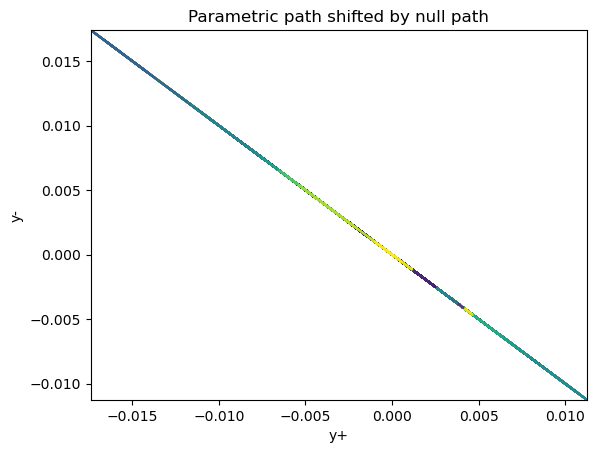

In [166]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax2.set_xlim(-0.001,0.001)
ax2.set_ylim(-0.001,0.001)

paths = []
shifted = []
n_ratios = [i for i in range(1,6)]
N1 = [1000 * i for i in range(1,3)]

c = plt.cm.viridis(n_ratios / np.max(n_ratios))

for N in N1:
    paths.append([])
    shifted.append([])
    for j in range(len(n_ratios)):
        paths[-1].append(parametric(n_ratios[j], N, ax1, c=c[j]))
        shifted[-1].append(parametric_shifted(n_ratios[j], N, paths[-1][-1], ax2))
legend_without_duplicate_labels(ax1)
plt.show()

(5, 1001)


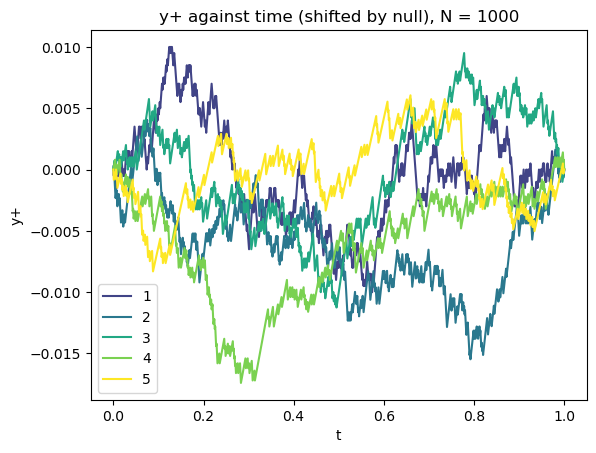

(5, 2001)


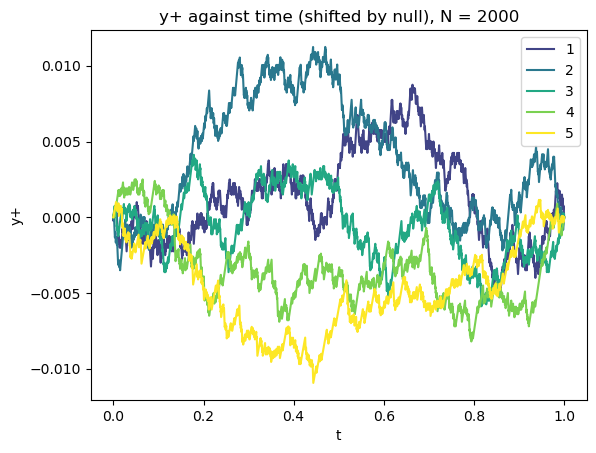

In [169]:
for i in range(len(N1)):
    shifted_plus = np.transpose(shifted[i], [1,0,2])[0]

    print(np.shape(shifted_plus))
    # print(np.shape(np.transpose(shifted[i])))
    t = np.linspace(0, 1, N1[i]+1)
    for j in range(len(n_ratios)):
        plt.plot(t, shifted_plus[j], label = f'ratio = {n_ratios[j]}', c = c[j])

    plt.xlabel("t")
    plt.ylabel("y+")
    plt.title(f"y+ against time (shifted by null), N = {N1[i]}")
    legend_without_duplicate_labels(plt.gca())
    plt.show()